Imaging Through Turbulence
==============


This notebook shows examples of using `aotools` to do the following:


It follows on from the propagation of light notebook.

In [1]:
import numpy
import matplotlib.pylab as plt
from tqdm import tqdm, trange, tqdm_notebook
from astropy.io import fits
%matplotlib inline
import aotools
from aotools.turbulence import infinitephasescreen
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.colors as colors
from aotools.turbulence.infinitephasescreen import PhaseScreenKolmogorov
j = 0+1j

Like before we need to set the parameters for the scale of our simulation and the strength of atmospheric turbulence we want to simulate.

In [2]:
# Set up parameters for creating phase screens
nx_size = 64
D = 1.
pxl_scale = D/nx_size
r0 = 0.32
L0 = 100
wind_speed = 10 #m/s - just arbitrarily set
stencil_length_factor = 32
wavelength = 500e-9

Before looking at aberrated PSFs first we will show the process of creating a simple PSF for a flat incident wavefront. To do this we impose a circular aperture on the phase screen in order to create a more realistic optical system. This can be done by multiplying the screen by the circular function `aotools.circle`.

In [3]:
pupil = aotools.circle(nx_size/2, nx_size)

This simply creates a mask which we can use to create more realistic simulations of optical systems.

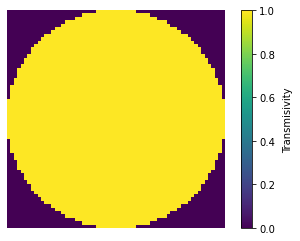

In [4]:
plt.figure()
plt.imshow(pupil)
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Transmisivity', labelpad=8)

The most simplistic way of simulating an imaging optical system is to use Fourier Transforms in order to calculate the PSF of the aperture.

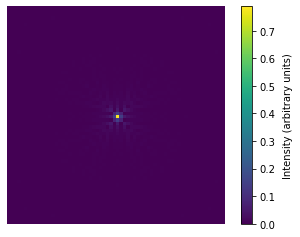

In [5]:
psf = aotools.ft2(pupil, delta=D/nx_size)

plt.figure()
plt.imshow(numpy.abs(psf))
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Intensity (arbitrary units)', labelpad=8)

Note that this PSF does not look particularly well sampled, although the spatial scales are included based on the input parameters. We can create a "smoother" image by padding Fourier Transforms for more pleasing plots. Note that this does not increase the resolution of the simulation, it just creates a nicer display.

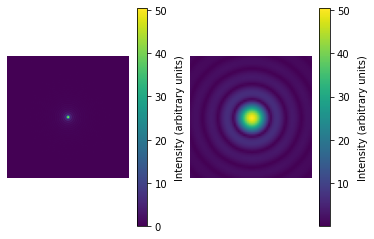

In [6]:
# Create padding to get an oversampled psf at the end to make it look nice
padded_pupil = numpy.zeros((nx_size*8, nx_size*8))
y, x = padded_pupil.shape
padded_pupil[:nx_size, :nx_size] = pupil

# Use AOtools to transform from the pupil to the focal plane
psf = aotools.ft2(padded_pupil, delta=D*8/nx_size,)

# Cut out the centre of the psf array for prettier plotting
psf_cut = psf[int(y/2-nx_size/2):int(y/2+nx_size/2), int(y/2-nx_size/2):int(y/2+nx_size/2)]

# Plot the PSF
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(numpy.abs(psf))
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Intensity (arbitrary units)', labelpad=8)
plt.subplot(1, 2, 2)
plt.imshow(numpy.abs(psf_cut))
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Intensity (arbitrary units)', labelpad=8)

The PSF produced is circularly symmetric, so we can use the `aotools.azimuthal_average` function in order to show the PSF more clearly.

Text(0, 0.5, 'relative intensity')

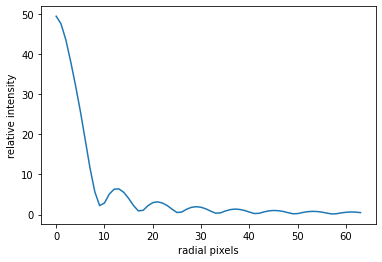

In [7]:
azi_avg = aotools.azimuthal_average(numpy.abs(psf))
plt.figure()
plt.plot(azi_avg[:nx_size])
plt.xlabel("radial pixels")
plt.ylabel("relative intensity")

Now we have these tools we can look at how turbulence affects these PSFs. First we need to create a phase screen object to interact with.

In [8]:
# Create the phase screen object using aotools
phase_screen = infinitephasescreen.PhaseScreenKolmogorov(nx_size, pxl_scale, r0, L0, stencil_length_factor=stencil_length_factor)

Now we impose a circular aperture on the phase screen in order to create a more realistic optical system. This can be done by multiplying the screen by the circular function `aotools.circle`.

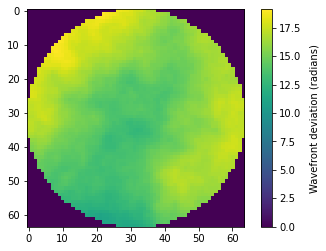

In [9]:
wavefront = phase_screen.scrn
wavefront *= aotools.circle(nx_size/2, nx_size)

plt.figure()
plt.imshow(wavefront)
cbar = plt.colorbar()
cbar.set_label('Wavefront deviation (radians)', labelpad=8)

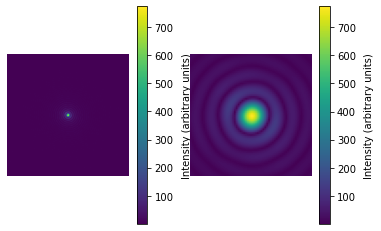

In [10]:
# Create padding to get an oversampled psf at the end to make it look nice
padded_pupil = numpy.zeros((nx_size*8, nx_size*8))
y, x = padded_pupil.shape
padded_pupil[:nx_size, :nx_size] = wavefront

# Use AOtools to transform from the pupil to the focal plane
psf = aotools.ft2(padded_pupil, delta=D*8/nx_size,)

# Cut out the centre of the psf array for prettier plotting
psf_cut = psf[int(y/2-nx_size/2):int(y/2+nx_size/2), int(y/2-nx_size/2):int(y/2+nx_size/2)]

# Plot the PSF
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(numpy.abs(psf))
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Intensity (arbitrary units)', labelpad=8)
plt.subplot(1, 2, 2)
plt.imshow(numpy.abs(psf_cut))
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Intensity (arbitrary units)', labelpad=8)

This is an instantanious snapshot of the turbulence, so generates and instantanious PSF. This is not the averaged PSF which a traditional "slow" camera would see. In order to generate this from simulation we would need to average many instances of turbulence.

In [11]:
n_scrns = 10
psfs = numpy.zeros((n_scrns, nx_size*8, nx_size*8))

for n in tqdm(range(n_scrns)):
    phase_screen = infinitephasescreen.PhaseScreenKolmogorov(nx_size, pxl_scale, r0, L0, stencil_length_factor=stencil_length_factor)
    padded_pupil[:nx_size, :nx_size] = phase_screen.scrn*aotools.circle(nx_size/2, nx_size)
    psf = aotools.ft2(padded_pupil, delta=D*8/nx_size,)
    psfs[n] = numpy.abs(psf)

average_psf = psfs.mean(0)

100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


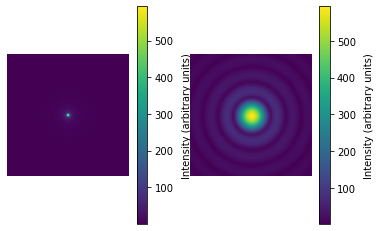

In [12]:
# Cut out the centre of the psf array for prettier plotting
psf_cut = average_psf[int(y/2-nx_size/2):int(y/2+nx_size/2), int(y/2-nx_size/2):int(y/2+nx_size/2)]

# Plot the PSF
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(numpy.abs(average_psf))
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Intensity (arbitrary units)', labelpad=8)
plt.subplot(1, 2, 2)
plt.imshow(numpy.abs(psf_cut))
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Intensity (arbitrary units)', labelpad=8)

We can also see how a PSF evolves as a phase screen evolves, similarly to how we saw the phase screen evolve previously.

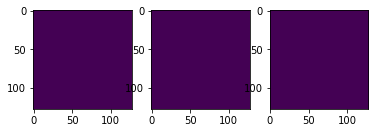

In [48]:
r0=0.02
frames=100
nx_size=128

phase_screen = infinitephasescreen.PhaseScreenKolmogorov(nx_size, pxl_scale, r0, L0, stencil_length_factor=stencil_length_factor)
padded_pupil = numpy.zeros((nx_size*8, nx_size*8))
average_psf = numpy.zeros((frames, nx_size, nx_size))

# Video of moving a phase screen and PSF
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3)
screen_image = ax1.imshow(numpy.zeros((nx_size, nx_size)))
psf_image = ax2.imshow(numpy.zeros((nx_size, nx_size)))
average_image = ax3.imshow(numpy.zeros((nx_size, nx_size)))

def init():
    screen_image.set_data(numpy.zeros((nx_size, nx_size)))
    psf_image.set_data(numpy.zeros((nx_size, nx_size)))
    average_image.set_data(numpy.zeros((nx_size, nx_size)))
    return (screen_image, psf_image, average_image,)

def animate(i):  
    phase_screen.add_row()
    wavefront = phase_screen.scrn
    screen_image.set_data(wavefront*aotools.circle(nx_size/2, nx_size))
    screen_image.autoscale()
    
    padded_pupil[:nx_size, :nx_size] = wavefront*aotools.circle(nx_size/2, nx_size)
    # Use AOtools to transform from the pupil to the focal plane
    psf = aotools.ft2(padded_pupil, delta=D*8/nx_size,)
    # Cut out the centre of the psf array for prettier plotting
    psf_cut = psf[int(y/2-nx_size/2):int(y/2+nx_size/2), int(y/2-nx_size/2):int(y/2+nx_size/2)]
    psf_image.set_data(numpy.abs(psf_cut))
    psf_image.autoscale()
    
    average_psf[i] = numpy.abs(psf_cut)
    average_image.set_data(average_psf[:i+1].mean(0))
    average_image.autoscale()
    
    return (screen_image, psf_image, average_image)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=20, 
                               blit=True)

In [49]:
HTML(anim.to_html5_video())

Extended Sources
================

We can apply PSFs we have generated here to extended sources using convolutions.

SyntaxError: invalid syntax (<ipython-input-1-9524e3e65f61>, line 1)